In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from simulate_strategy import simulate_strategy

### Strategy 4: make use of simple Bayesian reasoning.
This strategy uses simple Bayeisan resoning to determine the best strategy to play.

- $p$: The parameter of the Bernoulli distribution of L, is the probability of the opponent being fair.
- $L$: Bernouilli distribution with parameter p. Determines if the opponent is a cheater or not.
- $\theta$: The parameter of the Bernoulli distribution of $H$.
- $H_{1:N}$: $N$ samples of Bernouilli distribution with parameter $\theta$.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)\\
\end{align*}
$$

We know that:
$$
p = 0.5 \implies P(L=0) = P(L=1) = 0.5
$$
$$
\theta=0.5 \text{ if } L=0, \text{ and } \theta=0.75 \text{ if } L=1.
$$

In [2]:
class StrategyBayseian:

    def __init__(self, 
                 threshold = 0.75, 
                 n = 50,
                 flip_5_at_start = False):
        assert 0 <= threshold <= 1
        assert 0 <= n <= 500
        self.threshold = threshold 
        self.flip_5_at_start = flip_5_at_start

        # create probability table
        n_heads_array = np.arange(n).reshape(n, 1)
        n_tails_array = np.arange(n)
        p = np.zeros((n, n, 2))
        p[:, :, 0] = 0.5 ** n_heads_array * 0.5 ** n_tails_array
        p[:, :, 1] = 0.75 ** n_heads_array * (1-0.75) ** n_tails_array
        self.p = p / p.sum(axis=2, keepdims=True)

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def show_p(self, shape=None):
        if shape is None:
            shape = self.p.shape
        plt.imshow(self.p[:shape[0], :shape[1], 0])
        plt.title("Probability of being a fair player")
        plt.colorbar()
        plt.clim(0,1)
        plt.xlabel('Number of tails')
        plt.ylabel('Number of heads')
        plt.show()

    def strategy(self, n_heads, n_tails, flips_left):
        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left >= 5:
            return 1
        
        p = self.p[n_heads, n_tails, :]

        if np.max(p) > self.threshold or flips_left == 0:
            label = np.argmax(p)
            return label + 2
        else:
            return 0

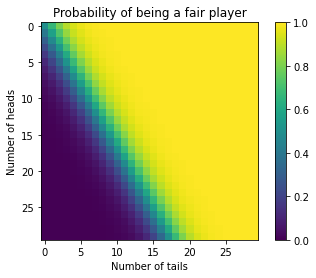

In [3]:
g = CoinGameSimulation()
scores = []
strat = StrategyBayseian(n=500)
strat.show_p(shape=(30, 30))

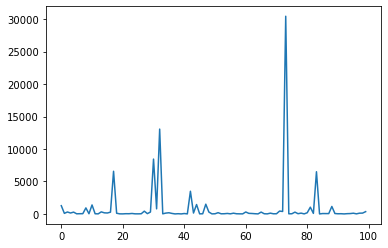

In [4]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)

    score = info["score"]
    scores.append(score)

plt.plot(scores, label="scores")
plt.show()

Here I simulate the strategy with and without the starting 5 flips.

In [5]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=100)

Score           mean: 467.06, std: 1502.02, median  72, min:   1, max: 10442
Labels per game mean: 574.59, std: 1837.25, median  92, min:   4, max: 12789
Flips per game  mean: 3895.70, std: 12474.20, median 628, min:  41, max: 86336
Flips per label mean:  6.78, std:  4.86, median   5, min:   0, max:  58
Reward          mean: -0.03, std:  6.78, median  -1, min: -30, max:  15
Accuracy: 0.813, Precision: 0.816, Recall: 0.812, F1-score: 0.814


In [6]:
strat.flip_5_at_start = True

In [7]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=100)

Score           mean: 111.92, std: 183.92, median  45, min:   0, max: 1006
Labels per game mean: 135.96, std: 218.40, median  57, min:   3, max: 1193
Flips per game  mean: 1072.15, std: 1725.25, median 458, min:  15, max: 9601
Flips per label mean:  7.89, std:  4.65, median   6, min:   0, max:  53
Reward          mean: -0.17, std:  8.72, median  -1, min: -30, max:  15
Accuracy: 0.823, Precision: 0.812, Recall: 0.832, F1-score: 0.822
